In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Search recall

In [230]:
df = pd.read_csv('../data/results/eval.csv')

df = df[df["term"] == "min_parking_spaces"][["town", "district", "correct_answer", "expected", "expected_normalized", "expected_extended", "actual", "actual_normalized", "confidence", "correct_page_searched", "correct_page_extracted", "gt_page", "searched_pages", "searched_pages_expanded", "extracted_pages"]]

In [231]:
sdf = df.groupby(by=['town', 'district']).agg({"correct_page_searched": "max"}).reset_index()

In [232]:
recall = sdf["correct_page_searched"].sum() / sdf.shape[0]
print("page search recall =", recall)

page search recall = nan


/var/folders/gf/tf25xxp14qn47s4gjl9jyjhr0000gn/T/ipykernel_32921/713171688.py:1: RuntimeWarning: invalid value encountered in scalar divide
  recall = sdf["correct_page_searched"].sum() / sdf.shape[0]


In [233]:
# Display all results for which no correct page was searched.
df.merge(sdf.query("correct_page_searched == 0"), on=["town", "district"]).query("~actual_normalized.isna()")

,correct_answer,expected,expected_normalized,expected_extended,actual,actual_normalized,confidence,correct_page_searched_x,correct_page_extracted,gt_page,searched_pages,searched_pages_expanded,extracted_pages,town,district,correct_page_searched_y


### Answer accuracy

In [234]:
gt = pd.read_csv('../data/ground_truth.csv')

In [235]:
gt_towns = list(gt['town'].unique())

In [236]:
df = pd.read_csv('../data/results/eval.csv')
term = 'min_parking_spaces'
df = df[df['term'] == term]

In [237]:
df_towns = list(df['town'].unique())

In [238]:
adf = df.groupby(by=['town', 'district']).agg({"correct_answer": "max"}).reset_index()

In [239]:
acc = adf["correct_answer"].sum() / adf.shape[0]
print("accuracy =", acc)

accuracy = nan


/var/folders/gf/tf25xxp14qn47s4gjl9jyjhr0000gn/T/ipykernel_32921/3677592276.py:1: RuntimeWarning: invalid value encountered in scalar divide
  acc = adf["correct_answer"].sum() / adf.shape[0]


In [240]:
df_inc = df.merge(adf.query("correct_answer == 0"), on=["town", "district"])

In [241]:
len(df_inc.query("correct_page_searched == 1"))

0

In [242]:
df_wrong = df_inc.query("~correct_answer_y")
df_cond_wrong = df_wrong.query("correct_page_searched == 1")
df_search_wrong = df_wrong.query("correct_page_searched == 0")

In [243]:
df_wrong

,term,expected,expected_extended,actual,confidence,correct_page_searched,correct_page_extracted,gt_page,searched_pages,searched_pages_expanded,extracted_pages,actual_normalized,expected_normalized,correct_answer_x,town,district,correct_answer_y


### Estimating performance plot

In [107]:
df = pd.read_csv('../data/results/eval_gpt-4.csv')
term = 'min_lot_size'
df = df[df['term'] == term]

In [108]:
# recall 
df_recall = df.groupby(by=['town', 'district']).agg({"correct_page_searched": "sum"}).reset_index()
df_recall["correct_search"] = df_recall["correct_page_searched"].apply(lambda x: 1 if x > 0 else 0)

# acc 
df_acc = df.groupby(by=['town', 'district']).agg({"correct_answer": "sum"}).reset_index()
df_acc["correct_acc"] = df_acc["correct_answer"].apply(lambda x: 1 if x > 0 else 0)

In [109]:
df_sample = df_recall.copy()
df_sample["correct_acc"] = df_acc["correct_acc"]

In [110]:
n_all = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

res_recalls = {}
res_accs = {}
recalls = []
accs = []

avg_over = 50

for n in n_all:
    res_recalls[n] = []
    res_accs[n] = []
    total_recall = 0
    total_accs = 0
    for i in range(avg_over):
        sample = df_sample.sample(n=n, replace=False)
        sample_recall = sample['correct_search'].sum() / n
        sample_acc = sample['correct_acc'].sum() / n
        res_recalls[n].append(sample_recall)
        res_accs[n].append(sample_acc)
        total_recall += sample_recall
        total_accs += sample_acc
    recalls.append(total_recall/avg_over)
    accs.append(total_accs/avg_over)

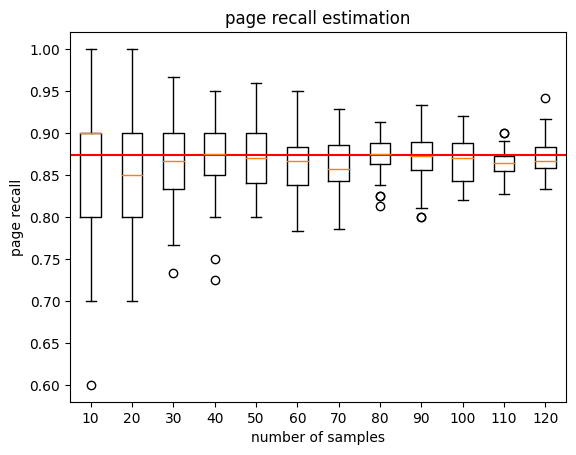

In [111]:
labels, data = [*zip(*res_recalls.items())]  # 'transpose' items to parallel key, value lists

# or backwards compatable    
labels, data = res_recalls.keys(), res_recalls.values()

plt.boxplot(data)
plt.axhline(y = .8734, color = 'r', linestyle = '-')
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel('number of samples')
plt.ylabel('page recall')
plt.title('page recall estimation')
plt.show()

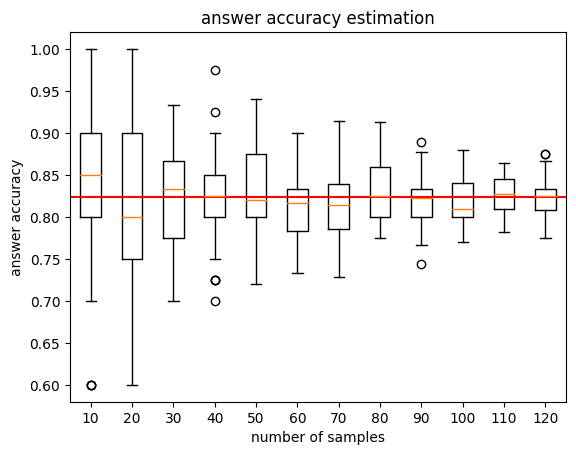

In [112]:
labels, data = [*zip(*res_accs.items())]  # 'transpose' items to parallel key, value lists

# or backwards compatable    
labels, data = res_accs.keys(), res_accs.values()

plt.boxplot(data)
plt.axhline(y = .8241, color = 'r', linestyle = '-')
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel('number of samples')
plt.ylabel('answer accuracy')
plt.title('answer accuracy estimation')
plt.show()

Text(0, 0.5, 'page recall')

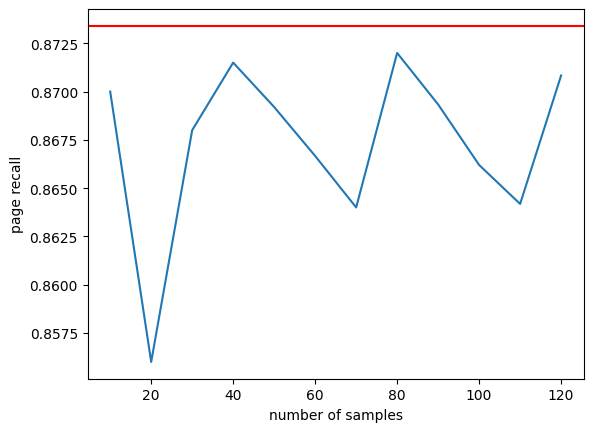

In [113]:
import matplotlib.pyplot as plt
plt.plot(n_all, recalls)
plt.axhline(y = .8734, color = 'r', linestyle = '-')
plt.xlabel('number of samples')
plt.ylabel('page recall')
#plt.ylim(0.5, 1)

Text(0, 0.5, 'answer accuracy')

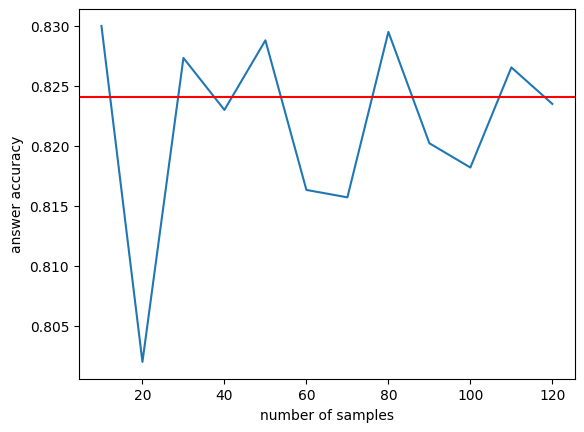

In [114]:
import matplotlib.pyplot as plt
plt.plot(n_all, accs)
plt.axhline(y = .8241, color = 'r', linestyle = '-')
plt.xlabel('number of samples')
plt.ylabel('answer accuracy')
#plt.ylim(0.5, 1)